In [1]:
import numpy as np
from skimage import io
import matplotlib.pyplot as plt
import torch
import cv2

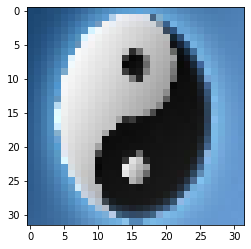

In [2]:
img_ori=io.imread('bagua.jpg')
img_ori=cv2.resize(img_ori, dsize=(32, 32), interpolation=cv2.INTER_CUBIC)
plt.imshow(img_ori)

In [3]:
img_ori.shape

(32, 32, 3)

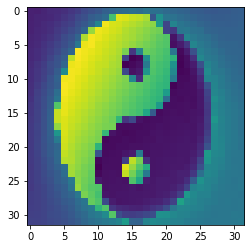

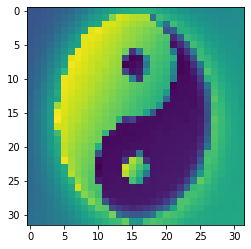

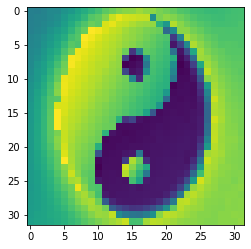

In [4]:
for i in range(0,3):
    plt.figure()
    plt.imshow(img_ori[:,:,i])

## 1.1 MaxPool2D
### 1.1.1 In pytorch

In [5]:
step_1_1=torch.nn.MaxPool2d(kernel_size=2,stride=1,padding=0,dilation=1, return_indices=False, ceil_mode=False)

In [6]:
img_ori.shape

(32, 32, 3)

In [7]:
img_temp=np.swapaxes(img_ori,1,2)
img_temp=np.swapaxes(img_temp,0,1)
img_temp=img_temp.reshape(1,img_temp.shape[0],img_temp.shape[1],img_temp.shape[2])
img_temp.shape

(1, 3, 32, 32)

In [8]:
def ShowOutput(model,img):
    output=model(img)
    output=output.data.numpy()
    for i in output:
        for j in range(0,output.shape[1]):
            plt.figure()
            plt.imshow(i[j])
    output=output[0]
    output=np.swapaxes(output,0,2)
    output=np.swapaxes(output,0,1)
    return output

In [9]:
img=torch.tensor(img_temp).float()

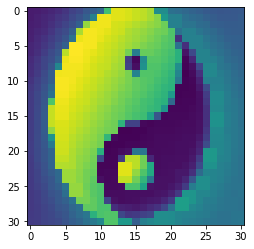

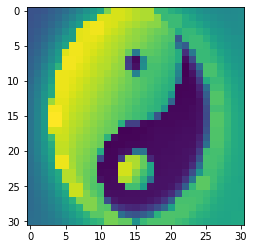

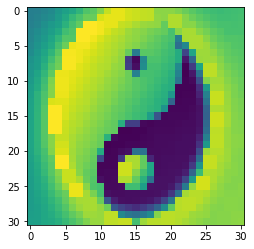

In [10]:
output_1_1=ShowOutput(step_1_1,img)

In [11]:
output_1_1.shape

(31, 31, 3)

In [12]:
img_temp[0,2,0:21,600:610]

array([], shape=(21, 0), dtype=uint8)

### 1.1.2 Scratch

In [13]:
def getMax(arr):
    imax=arr.shape[0]
    jmax=arr.shape[1]
    max_num=arr[0][0]
    for i in range(0,imax):
        for j in range(0,jmax):
            max_num=max([max_num,arr[i][j]])
    return max_num

def our_MaxPool2D(img):
    imax=img.shape[0]
    jmax=img.shape[1]
    channel=img.shape[2]
    output=np.zeros((imax-1,jmax-1,channel))
    for i in range(0,imax-1):
        for j in range(0,jmax-1):
            for k in range(0,channel):
                output[i,j,k]=getMax(img[i:i+2,j:j+2,k])
    return output

In [14]:
def ShowOurOutput(output_img):
    channel=output_img.shape[2]
    for i in range(0,channel):
        plt.figure()
        plt.imshow(output_img[:,:,i])

In [15]:
our_output_1_1=our_MaxPool2D(img_ori)
our_output_1_1.shape

(31, 31, 3)

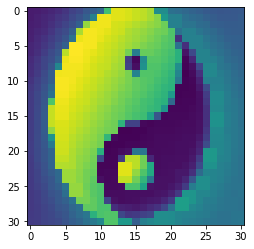

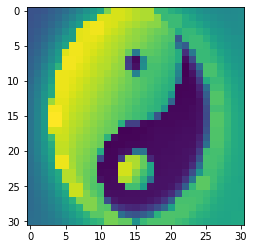

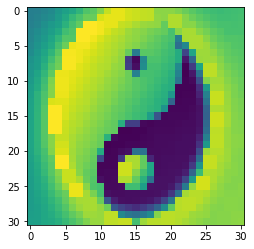

In [16]:
ShowOurOutput(our_output_1_1)

In [17]:
def CompareOutput(img,our_img):
    channel=img.shape[2]
    result=True
    for i in range(0,channel):
        result=(result and (img[:,:,i]==our_img[:,:,i]).all())
    return result

In [18]:
CompareOutput(output_1_1,our_output_1_1)

True

## 1.2 Average Pooling
### 1.2.1 In pytorch

In [19]:
step_1_2=torch.nn.AvgPool2d(kernel_size=2, stride=1, padding=0,ceil_mode=False, count_include_pad=True,divisor_override=None)

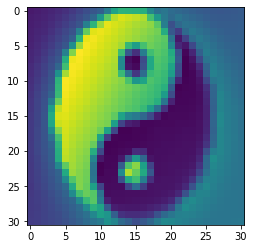

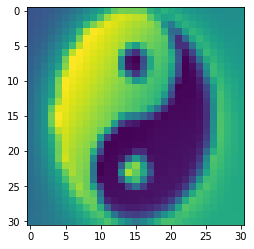

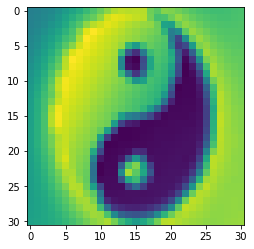

In [20]:
output_1_2=ShowOutput(step_1_2,img)

In [21]:
output_1_2.shape

(31, 31, 3)

### 1.2.2 Scratch

In [22]:
def getAvg(arr):
    imax=arr.shape[0]
    jmax=arr.shape[1]
    sum_num=0

    for i in range(0,imax):
        for j in range(0,jmax):
            sum_num=sum([sum_num,arr[i][j]])
    return sum_num/4

def our_AvgPool2D(img):
    imax=img.shape[0]
    jmax=img.shape[1]
    channel=img.shape[2]
    output=np.zeros((imax-1,jmax-1,channel))
    for i in range(0,imax-1):
        for j in range(0,jmax-1):
            for k in range(0,channel):
                output[i,j,k]=getAvg(img[i:i+2,j:j+2,k])
    return output

In [23]:
our_output_1_2=our_AvgPool2D(img_ori)
our_output_1_2.shape

(31, 31, 3)

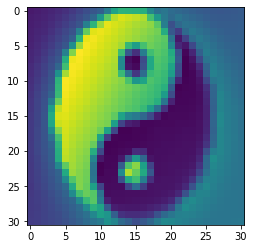

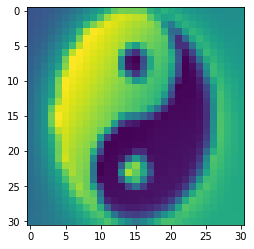

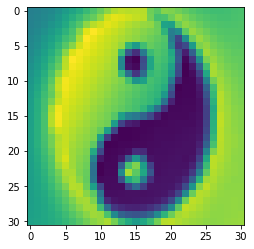

In [24]:
ShowOurOutput(our_output_1_2)

In [25]:
CompareOutput(output_1_2,our_output_1_2)

True

## 1.3 Conv2D - Version 1
### 1.3.1 In pytorch

In [26]:
step_1_3=torch.nn.Conv2d(in_channels=3, out_channels=6,kernel_size=3, stride=1, padding=0, dilation=1, groups=1,bias=True, padding_mode='zeros')

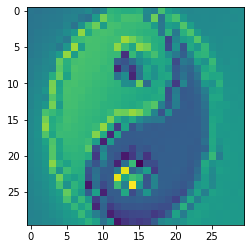

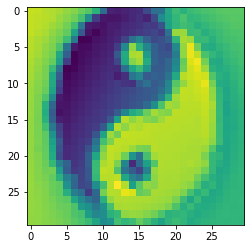

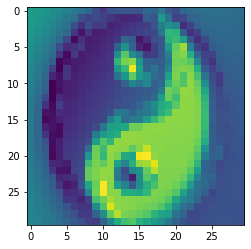

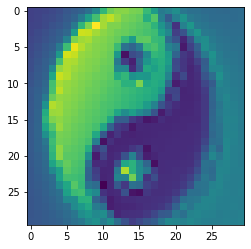

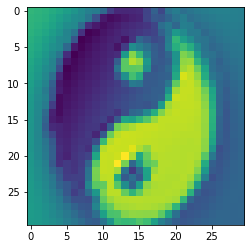

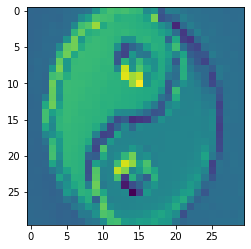

In [27]:
output_1_3=ShowOutput(step_1_3,img)

In [28]:
output_1_3.shape

(30, 30, 6)

In [29]:
torch.nn.init.calculate_gain('conv2d')

1

In [30]:
step_1_3.weight.shape

torch.Size([6, 3, 3, 3])

In [31]:
w=step_1_3.weight.data.numpy()
w.shape

(6, 3, 3, 3)

In [32]:
b=step_1_3.bias.data.numpy()
b

array([-0.06852119,  0.07251625,  0.02950616,  0.00215195,  0.1742327 ,
       -0.16214126], dtype=float32)

### 1.3.2 Scratch

In [33]:
def our_Conv2d(w,img,b):
    output_channels=w.shape[0]
    imax=img.shape[0]
    jmax=img.shape[1]
    input_channels=img.shape[2]
    output=np.zeros((imax-2,jmax-2,output_channels))

    for i in range(0,imax-2):
        for j in range(0,imax-2):
            for k in range(0,output_channels):
                output[i,j,k]=sum(sum(w[k,0]*img[i:i+3,j:j+3,0]))+sum(sum(w[k,1]*img[i:i+3,j:j+3,1]))+sum(sum(w[k,2]*img[i:i+3,j:j+3,2]))+b[k]
    
    return output

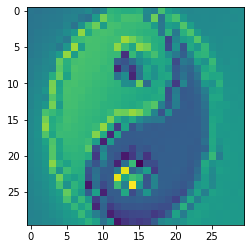

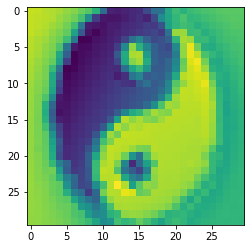

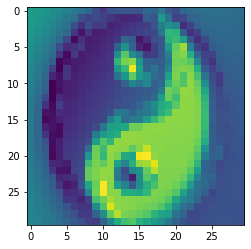

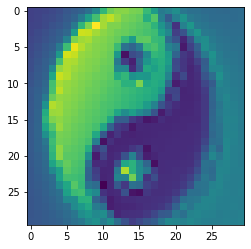

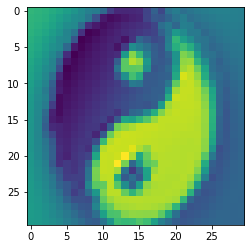

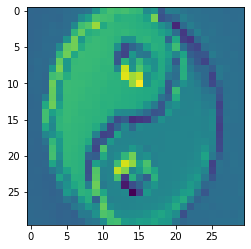

In [34]:
our_output_1_3=our_Conv2d(w,img_ori,b)
ShowOurOutput(our_output_1_3)

In [35]:
def CompareOutput_v2(img,our_img):
    diff=img-our_img
    return (abs(diff)<0.00013).all()

In [36]:
CompareOutput_v2(output_1_3,our_output_1_3)

True

## 1.4 Conv2d - V2
### 1.4.1 In pytorch

In [37]:
step_1_4=torch.nn.Conv2d(in_channels=3, out_channels=6,kernel_size=5, stride=2, padding=0, dilation=2, groups=1,bias=True, padding_mode='zeros')

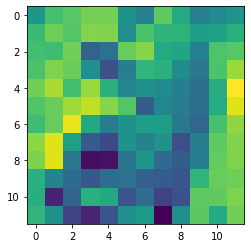

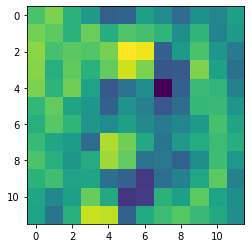

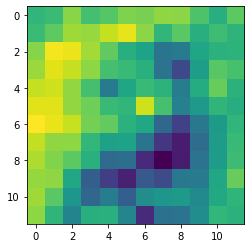

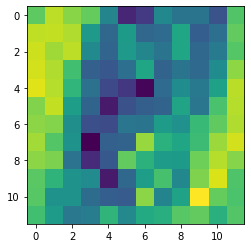

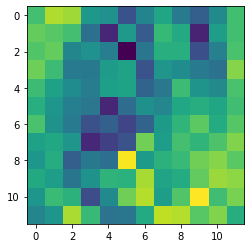

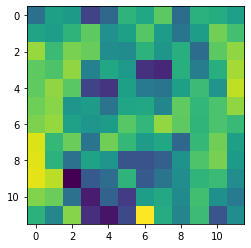

In [38]:
output_1_4=ShowOutput(step_1_4,img)

In [39]:
output_1_4.shape

(12, 12, 6)

In [40]:
img_ori.shape

(32, 32, 3)

### 1.4.2 Scratch

In [42]:
def our_Conv2d_v2(w,img,b,stride):
    output_channels=w.shape[0]
    imax=img.shape[0]//stride-4
    jmax=img.shape[1]//stride-4
    input_channels=img.shape[2]
    output=np.zeros((imax,jmax,output_channels))

    for i_new in range(0,imax):
        print(i_new)
        for j_new in range(0,imax):
            i=i_new*2
            j=j_new*2
            for k in range(0,output_channels):
                res=0
                for l in range(0,input_channels):
                    x=np.array([
                                [img[i  ,j,l],img[i  ,j+2,l],img[i  ,j+4,l],img[i  ,j+6,l],img[i  ,j+8,l]],
                                [img[i+2,j,l],img[i+2,j+2,l],img[i+2,j+4,l],img[i+2,j+6,l],img[i+2,j+8,l]],
                                [img[i+4,j,l],img[i+4,j+2,l],img[i+4,j+4,l],img[i+4,j+6,l],img[i+4,j+8,l]],
                                [img[i+6,j,l],img[i+6,j+2,l],img[i+6,j+4,l],img[i+6,j+6,l],img[i+6,j+8,l]],
                                [img[i+8,j,l],img[i+8,j+2,l],img[i+8,j+4,l],img[i+8,j+6,l],img[i+8,j+8,l]]
                                ])
                    res=res+sum(sum(w[k,l]*x))
                output[i_new,j_new,k]=res+b[k]
    
    return output

In [43]:
b=step_1_4.bias.data.numpy()
b

array([-0.10520472, -0.07179406, -0.05766683,  0.01804583,  0.08076832,
       -0.00303946], dtype=float32)

In [44]:
w=step_1_4.weight.data.numpy()
w.shape

(6, 3, 5, 5)

In [45]:
our_output_1_4=our_Conv2d_v2(w,img_ori,b,2)

0
1
2
3
4
5
6
7
8
9
10
11


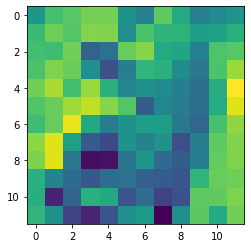

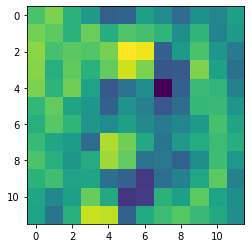

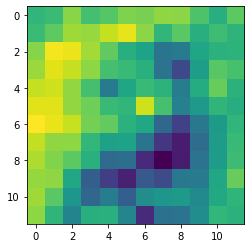

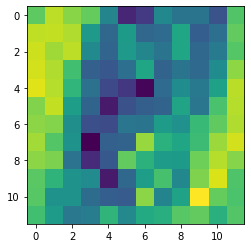

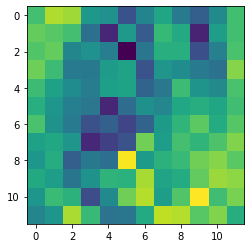

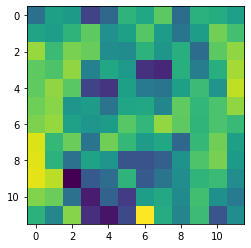

In [46]:
ShowOurOutput(our_output_1_4)

In [47]:
CompareOutput_v2(output_1_4,our_output_1_4)

True

## 1.5 ConvTranspose2d
### 1.5.1 In pytorch

In [48]:
step_1_5=torch.nn.ConvTranspose2d(in_channels=3, out_channels=4,kernel_size=3, stride=1, padding=0, output_padding=0,groups=1, bias=True, dilation=1, padding_mode='zeros')

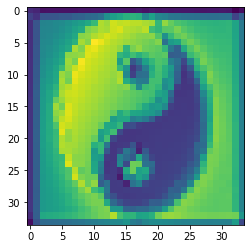

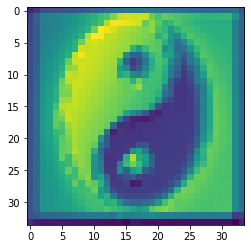

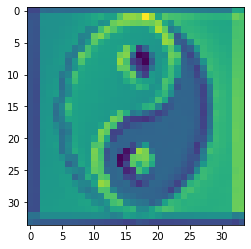

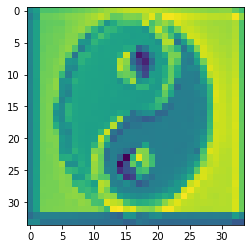

In [49]:
output_1_5=ShowOutput(step_1_5,img)

In [50]:
output_1_5.shape

(34, 34, 4)

In [51]:
img_ori.shape

(32, 32, 3)

In [52]:
w=step_1_5.weight.data.numpy()
w.shape

(3, 4, 3, 3)

In [53]:
b=step_1_5.bias.data.numpy()
b

array([-0.13887432, -0.02114315, -0.1319463 ,  0.10831828], dtype=float32)

### 1.5.2 Scratch

In [54]:
def trans_conv(X, K):
    h, w = K.shape
    Y = np.zeros((X.shape[0] + h - 1, X.shape[1] + w - 1))
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            Y[i:i + h, j:j + w] += X[i, j] * K
    return Y

def our_ConvTranspose2d(w,img,b):
    input_channels=w.shape[0]
    output_channels=w.shape[1]
    imax=img.shape[0]
    jmax=img.shape[0]
    output=np.zeros((imax+2,jmax+2,output_channels))    


    for out_c in range(0,output_channels):
        output[:,:,out_c] += trans_conv(img[:,:,0],w[0,out_c]) + trans_conv(img[:,:,1],w[1,out_c]) + trans_conv(img[:,:,2],w[2,out_c]) + b[out_c]
    
    return output



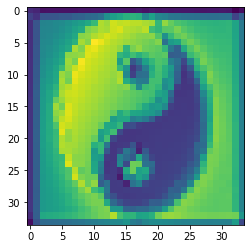

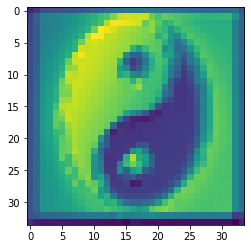

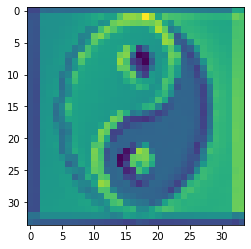

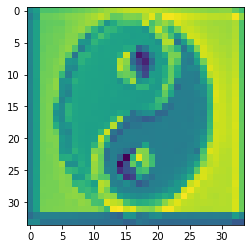

In [55]:
our_output_1_5=our_ConvTranspose2d(w,img_ori,b)
ShowOurOutput(our_output_1_5)

In [56]:
CompareOutput_v2(output_1_5,our_output_1_5)

True

## 2.1 Flatten
### 2.1.1 In pytorch

In [58]:
output_2_1=torch.flatten(img, start_dim=0, end_dim=-1)

In [60]:
output_2_1=np.array(output_2_1)
output_2_1.shape

(3072,)

In [65]:
output_2_1[32*32:32*32+32]

array([ 71.,  70.,  74.,  78.,  81.,  85.,  92., 100., 109., 121., 133.,
       140., 148., 155., 158., 160., 163., 161., 161., 155., 150., 145.,
       137., 134., 129., 128., 124., 123., 125., 125., 127., 128.],
      dtype=float32)

In [66]:
img_ori[0,:,1]

array([ 71,  70,  74,  78,  81,  85,  92, 100, 109, 121, 133, 140, 148,
       155, 158, 160, 163, 161, 161, 155, 150, 145, 137, 134, 129, 128,
       124, 123, 125, 125, 127, 128], dtype=uint8)

### 2.1.2 Scratch

In [71]:
def our_Flatten(img):
    imax=img.shape[0]
    jmax=img.shape[1]
    channels=img.shape[2]
    output=[]

    for c in range(0,channels):
        for i in range(0,imax):
            for j in range(0,jmax):
                output.append(img[i,j,c])
    return np.array(output)

In [72]:
our_output_2_1=our_Flatten(img_ori)
our_output_2_1

array([ 28,  27,  31, ..., 211, 211, 214], dtype=uint8)

In [75]:
def CompareOutPut_singleChannel(arr1,arr2):
    return (arr1==arr2).all()

In [76]:
CompareOutPut_singleChannel(output_2_1,our_output_2_1)

True

## 2.2 Sigmoid
### 2.2.1 In pytorch

In [98]:
output_2_2=torch.sigmoid(img/255, out=None)
output_2_2

tensor([[[[0.5274, 0.5264, 0.5304,  ..., 0.5730, 0.5749, 0.5759],
          [0.5274, 0.5304, 0.5313,  ..., 0.5749, 0.5759, 0.5768],
          [0.5284, 0.5304, 0.5343,  ..., 0.5759, 0.5768, 0.5788],
          ...,
          [0.5498, 0.5508, 0.5547,  ..., 0.5987, 0.5977, 0.5987],
          [0.5508, 0.5518, 0.5547,  ..., 0.5987, 0.6006, 0.5996],
          [0.5527, 0.5527, 0.5547,  ..., 0.5987, 0.5996, 0.6015]],

         [[0.5692, 0.5682, 0.5720,  ..., 0.6202, 0.6220, 0.6229],
          [0.5692, 0.5720, 0.5730,  ..., 0.6220, 0.6229, 0.6238],
          [0.5701, 0.5720, 0.5759,  ..., 0.6229, 0.6238, 0.6257],
          ...,
          [0.5921, 0.5949, 0.5987,  ..., 0.6466, 0.6457, 0.6466],
          [0.5930, 0.5959, 0.5987,  ..., 0.6466, 0.6483, 0.6474],
          [0.5949, 0.5968, 0.5987,  ..., 0.6466, 0.6466, 0.6492]],

         [[0.6099, 0.6090, 0.6127,  ..., 0.6678, 0.6695, 0.6704],
          [0.6099, 0.6127, 0.6137,  ..., 0.6695, 0.6704, 0.6712],
          [0.6109, 0.6127, 0.6165,  ..., 0

In [103]:
output_2_2=output_2_2.data.numpy()[0]
output_2_2=np.swapaxes(output_2_2,0,2)
output_2_2=np.swapaxes(output_2_2,0,1)

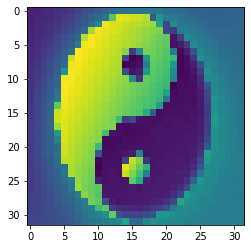

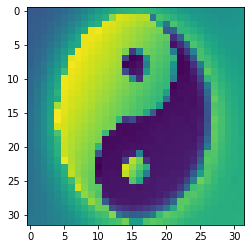

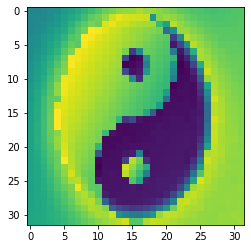

In [105]:
ShowOurOutput(output_2_2)

### 2.2.2 Scratch

In [82]:
import math

In [99]:
def our_sigmoid(img):
    return 1/(1+np.exp(-img))

In [101]:
our_output_2_2=our_sigmoid(img_ori/255)
our_output_2_2.shape

(32, 32, 3)

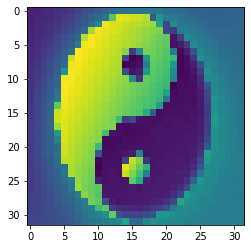

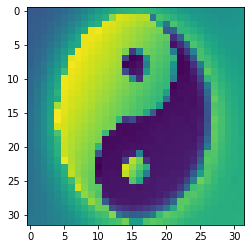

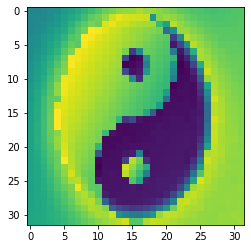

In [106]:
ShowOurOutput(our_output_2_2)

In [107]:
CompareOutput_v2(output_2_2,our_output_2_2)

True

## 2.3 Roi Pool
### 2.3.1 In pytorch

In [108]:
import torchvision

In [356]:
output_2_3=torchvision.ops.roi_pool(img,boxes=torch.tensor([[0,2,11,2,11]]).float(),output_size=(4,4), spatial_scale= 1.0)
output_2_3

tensor([[[[ 58.,  58.,  58.,  58.],
          [ 58.,  58.,  58.,  58.],
          [ 58.,  58.,  58.,  58.],
          [ 58.,  58.,  58.,  58.]],

         [[112., 112., 112., 112.],
          [112., 112., 112., 112.],
          [112., 112., 112., 112.],
          [112., 112., 112., 112.]],

         [[159., 159., 159., 159.],
          [159., 159., 159., 159.],
          [159., 159., 159., 159.],
          [159., 159., 159., 159.]]]])

In [357]:
output_2_3=Scale(output_2_3)
output_2_3

array([[[ 58., 112., 159.],
        [ 58., 112., 159.],
        [ 58., 112., 159.],
        [ 58., 112., 159.]],

       [[ 58., 112., 159.],
        [ 58., 112., 159.],
        [ 58., 112., 159.],
        [ 58., 112., 159.]],

       [[ 58., 112., 159.],
        [ 58., 112., 159.],
        [ 58., 112., 159.],
        [ 58., 112., 159.]],

       [[ 58., 112., 159.],
        [ 58., 112., 159.],
        [ 58., 112., 159.],
        [ 58., 112., 159.]]], dtype=float32)

In [184]:
def Scale(img):
    img=img.data.numpy()[0]
    img=np.swapaxes(img,0,2)
    img=np.swapaxes(img,0,1)
    return img

### 2.3.2 Scratch

In [359]:
def our_RoiPool(img_ori, boxes, output_size):
    start_i=boxes[1]
    end_i=boxes[2]+1
    start_j=boxes[3]
    end_j=boxes[4]+1
    img=img_ori[start_i:end_i,start_j:end_j]
    output=np.zeros((output_size[0],output_size[1],3))
    for i in range(0,3):
        output[:,:,i]+=img[-1,0,i]

    return output

In [360]:
our_output_2_3=our_RoiPool(img_ori,[0,2,11,2,11],(4,4))
our_output_2_3

array([[[ 58., 112., 159.],
        [ 58., 112., 159.],
        [ 58., 112., 159.],
        [ 58., 112., 159.]],

       [[ 58., 112., 159.],
        [ 58., 112., 159.],
        [ 58., 112., 159.],
        [ 58., 112., 159.]],

       [[ 58., 112., 159.],
        [ 58., 112., 159.],
        [ 58., 112., 159.],
        [ 58., 112., 159.]],

       [[ 58., 112., 159.],
        [ 58., 112., 159.],
        [ 58., 112., 159.],
        [ 58., 112., 159.]]])

In [361]:
CompareOutput(output_2_3,our_output_2_3)

True

## 2.4 Batch Normalization
### 2.4.1 In pytorch

In [262]:
mean=torch.tensor([np.mean(img_ori[:,:,0]),np.mean(img_ori[:,:,1]),np.mean(img_ori[:,:,2])]).float()
std=torch.tensor([np.std(img_ori[:,:,0]),np.std(img_ori[:,:,1]),np.std(img_ori[:,:,2])]).float()

In [267]:
output_2_4=torch.nn.functional.batch_norm(img,running_mean=mean,running_var=std,weight=None, bias=None, training=False, momentum=0.1,eps=1e-05)

In [268]:
output_2_4=Scale(output_2_4)
output_2_4.shape

(32, 32, 3)

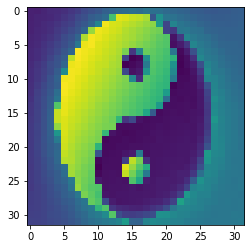

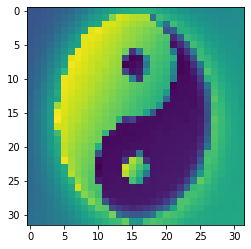

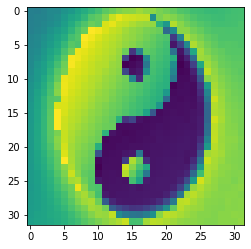

In [294]:
ShowOurOutput(output_2_4)

In [292]:
output_2_4[0,1,0]

-8.859161

### 2.4.2 Scratch

In [293]:
def our_BatchNormalization(img,mean,std,eps):
    h,w,c=img.shape
    output=np.zeros((h,w,c))
    output[:,:,0]+=(img[:,:,0]-mean[0])/math.sqrt(std[0]+eps)
    output[:,:,1]+=(img[:,:,1]-mean[1])/math.sqrt(std[1]+eps)
    output[:,:,2]+=(img[:,:,2]-mean[2])/math.sqrt(std[2]+eps)
    return output

In [296]:
our_output_2_4=our_BatchNormalization(img_ori,mean.data.numpy(),std.data.numpy(),1e-05)

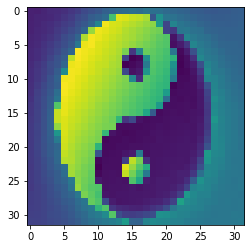

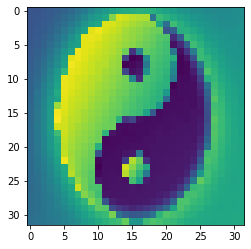

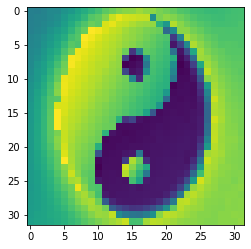

In [298]:
ShowOurOutput(our_output_2_4)

In [297]:
CompareOutput_v2(our_output_2_4,our_output_2_4)

True

## 2.5 Cross Entropy
### 2.5.1 In pytorch

In [496]:
target=torch.randint(0,3,(1,32,32))

In [501]:
output_2_5=torch.nn.functional.cross_entropy(img/255, target, weight=None,size_average=None, ignore_index=-100, reduce=None,reduction='mean')
output_2_5

tensor(1.1025)

### 2.5.2 Scratch

In [508]:
def CrossEntropyLoss(p, y):
    return -math.log(math.exp(p[y])/sum(np.exp(p)))

def our_CrossEntropy(img,target):
    w,h=target.shape
    res=0
    for i in range(0,32):
        for j in range(0,32):
            res+=CrossEntropy(img[i,j,:],target[i,j])

    return res/(w*h)

In [513]:
our_output_2_5=our_CrossEntropy(img_ori/255,target[0].data.numpy())
our_output_2_5

1.1024883432968042

In [514]:
CompareOutput_v2(output_2_5.data.numpy(),np.array(our_output_2_5))

True

## 2.5 MSE Loss
### 2.5.1 In pytorch

In [515]:
output_2_5=torch.nn.functional.mse_loss(img/255, target, size_average=None,reduce=None, reduction='mean')
output_2_5

<ipython-input-515-e790dcb5f615>:1: UserWarning: Using a target size (torch.Size([1, 32, 32])) that is different to the input size (torch.Size([1, 3, 32, 32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  output_2_5=torch.nn.functional.mse_loss(img/255, target, size_average=None,reduce=None, reduction='mean')


tensor(1.0483)

In [ ]:
### 2.5.2 Scratch

In [527]:
def MSELoss(pred,y):
    return sum((pred-y)**2)/pred.shape[0]

def our_MSELoss(img,target):
    w,h=target.shape
    res=0
    for i in range(0,32):
        for j in range(0,32):
            res+=MSELoss(img[i,j],target[i,j])
    return res/(w*h)

In [528]:
our_output_2_5=our_MSELoss(img_ori/255,target[0].data.numpy())
our_output_2_5

1.0483438761534023

In [529]:
CompareOutput_v2(output_2_5.data.numpy(),our_output_2_5)

True